# Experiment 4 - natural VS synthetic voice

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import re
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

### Dataset creation

In [2]:
folder = 'voice_recognition/vowels/'
naming_pattern = r"^(s|n).*[.]wav$"

# Getting files name matching experiment
all_files = os.listdir(folder)
matching_files = [filename for filename in all_files if re.search(naming_pattern, filename)]

# Gathering data and building dataset
dataset = []
nbNatural = 0
nbSynth = 0

for filename in matching_files:
    sample_rate, X = wav.read(os.path.join(folder, filename))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
    
    ceps_avg = np.mean(ceps, axis=0)
    #ceps_std = np.std(ceps, axis=0)

    # Adding class
    if (filename[0] == "n"):
        row = np.append(ceps_avg, 1)
        nbNatural += 1
    else:
        row = np.append(ceps_avg, -1)
        nbSynth += 1

    # Add to dataset
    dataset.append(row)

dataset = np.array(dataset)
print("Natural " + str(nbNatural))
print("Synthetic " + str(nbSynth))
print(dataset.shape)
print(dataset)



Men 72
Women 288
(360, 14)
[[ 20.83553285  13.14986301  -9.66938018 ... -19.36086468 -16.14554454
   -1.        ]
 [ 21.08101329   4.73696633  -9.2959752  ... -23.62248603 -11.13881792
   -1.        ]
 [ 21.20387031  13.72238626  -8.3806115  ... -10.52878694  -3.11467664
   -1.        ]
 ...
 [ 20.38439835  13.94362427 -25.92721803 ... -23.06276166  -2.23797472
   -1.        ]
 [ 20.77528098  16.43196257 -23.49818458 ... -13.74396024  13.05408851
   -1.        ]
 [ 20.7559793   26.09548041 -14.09198541 ... -12.23463554  -5.94156654
   -1.        ]]


## Neural network parameters

(default from notebook 9)

In [3]:
N_INITS = 10
EPOCHS = 300
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [4]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)
print('Testing over')        

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing over


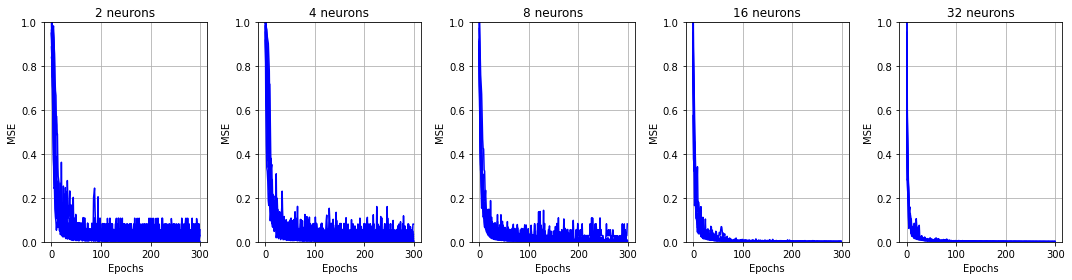

In [5]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In [6]:
EPOCHS = 200
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [7]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        
print('Testing over')         

Testing 2 neurons...


ValueError: shapes (15,) and (27,2) not aligned: 15 (dim 0) != 27 (dim 0)

In [ ]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [ ]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

In [ ]:
nn = mlp.MLP([13,15,1], 'tanh')

In [ ]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=150,
                                                          threshold=0.0)

In [ ]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)